In [5]:
! chmod 600 /content/kaggle.json

! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:19<00:00, 18.4MB/s]
100% 346M/346M [00:19<00:00, 18.5MB/s]


In [6]:
import zipfile
zip_file = zipfile.ZipFile('/content/intel-image-classification.zip')
zip_file.extractall('/tmp/')

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import pathlib
import tensorflow as tf
%matplotlib inline

from keras_preprocessing.image import ImageDataGenerator

In [8]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=5,
    zoom_range=(0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format="channels_last",
    validation_split=0.0,
    dtype=tf.float32,
)

In [9]:
import shutil

# absolute path
src_path = r"/tmp/seg_test/seg_test"
dst_path = r"/tmp/seg_train/seg_traint"
shutil.move(src_path, dst_path)

'/tmp/seg_train/seg_traint'

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rescaled = ImageDataGenerator(rescale=1.0 / 255,
    rotation_range=5,
    zoom_range=(0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format="channels_last",
    validation_split=0.2,
    dtype=tf.float32)
train_set = tf.keras.utils.image_dataset_from_directory('/tmp/seg_train/seg_train', image_size = (128,128), batch_size=32, label_mode = 'categorical', subset='training',  validation_split = 0.2, seed=42)
test_set = tf.keras.utils.image_dataset_from_directory('/tmp/seg_train/seg_train', image_size = (128,128), batch_size=32, label_mode = 'categorical', subset='validation', validation_split = 0.2, seed=42)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #1st layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #2nd layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #3rd layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),  #4th layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')                                                       
])

In [12]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80 and logs.get('val_accuracy')>0.80):
      self.model.stop_training = True
      print("\n akurasi dari training set and the validation set telah terpenuhi > 80%!")
callbacks = myCallback()

In [15]:
model.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set, shuffle=True, epochs=50, validation_data=test_set, verbose=2, callbacks=[callbacks])

Epoch 1/50
351/351 - 17s - loss: 0.4645 - accuracy: 0.8298 - val_loss: 0.5859 - val_accuracy: 0.7912 - 17s/epoch - 48ms/step
Epoch 2/50
351/351 - 14s - loss: 0.4529 - accuracy: 0.8341 - val_loss: 0.6053 - val_accuracy: 0.7887 - 14s/epoch - 39ms/step
Epoch 3/50
351/351 - 14s - loss: 0.4540 - accuracy: 0.8359 - val_loss: 0.6168 - val_accuracy: 0.7904 - 14s/epoch - 39ms/step
Epoch 4/50
351/351 - 14s - loss: 0.4323 - accuracy: 0.8442 - val_loss: 0.5905 - val_accuracy: 0.7847 - 14s/epoch - 39ms/step
Epoch 5/50
351/351 - 14s - loss: 0.4276 - accuracy: 0.8439 - val_loss: 0.6733 - val_accuracy: 0.7883 - 14s/epoch - 39ms/step
Epoch 6/50

 akurasi dari training set and the validation set telah terpenuhi > 80%!
351/351 - 14s - loss: 0.4360 - accuracy: 0.8369 - val_loss: 0.5918 - val_accuracy: 0.8001 - 14s/epoch - 39ms/step


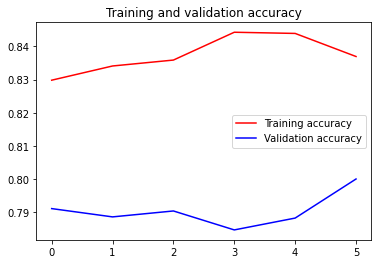

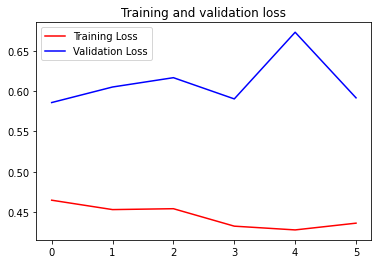

In [16]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('RPS_model.tflite', 'wb') as f:
  f.write(tflite_model)